## Drug-Target Interaction (DTI) prediction

DeepPurpose enables an easy interface to do two important applications of DTI prediction: virtual screening and drug repurposing. DeepPurpose works specifically for drug-target interaction prediction. Drug-target interaction (DTI) measures the binding affinity of drug molecules to the protein targets.

Programming workflow: 

* Load the dataset from a local file or load a DeepPurpose benchmark dataset.
* Specify the names of compound and protein encoders. 
* Split the dataset into training, validation and testing sets using data_process function.
* Create a configuration file and specify model parameters.
* Initialize a model using the configuration file. 
* Train the model using train function and monitor the progress of training and performance metrics.

ref: https://academic.oup.com/bioinformatics/article/36/22-23/5545/6020256

Github : https://github.com/kexinhuang12345/DeepPurpose


## Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import collections
from collections import OrderedDict
from matplotlib.pyplot import cm
import deepchem as dc

In [2]:
import DeepPurpose

In [3]:
from DeepPurpose import utils, DTI, dataset
from DeepPurpose import DTI as models

## Data loading

DeepPurpose takes in a NumPy array of drug’s SMILES strings (X_drugs), a NumPy array of target protein’s amino acid sequence (X_targets), and a NumPy array of labels (y).

DeepPurpose also provides benchmark dataset loaders (DAVIS/KIBA/BindingDB) to ease preprocessing.
DeepPurpose feeds the learned protein and compound embeddings into an MLP decoder to generate predictions.

In [4]:
def convert_y_unit(y, from_, to_):
    array_flag = False
    if isinstance(y, (int, float)):
        y = np.array([y])
        array_flag = True
    y = y.astype(float)    
    # basis as nM
    if from_ == 'nM':
        y = y
    elif from_ == 'p':
        y = 10**(-y) / 1e-9

    if to_ == 'p':
        zero_idxs = np.where(y == 0.)[0]
        y[zero_idxs] = 1e-10
        y = -np.log10(y*1e-9)
    elif to_ == 'nM':
        y = y

    if array_flag:
        return y[0]
    return y

In [5]:

affinity = pd.read_csv('DAVIS/affinity.txt', header=None, sep = ' ')

with open('DAVIS/target_seq.txt') as f:
    target = json.load(f)

with open('DAVIS/SMILES.txt') as f:
    drug = json.load(f)

   
target = list(target.values())
drug = list(drug.values())

SMILES = []
Target_seq = []
y = []

In [6]:
for i in range(len(drug)):
        for j in range(len(target)):
            SMILES.append(drug[i])
            Target_seq.append(target[j]) 
            y.append(affinity.values[i, j])

            

print('Done!')

Done!


In [7]:
y = convert_y_unit(np.array(y), 'nM', 'p').tolist()

In [8]:
df = pd.DataFrame(list(zip(SMILES,Target_seq,y),),columns =['Drug', 'Target','BA_score'])

In [9]:
df.head()

,Drug,Target,BA_score
0,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...,7.366532
1,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
2,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
3,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000
4,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000


In [10]:
## data loader 
#X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)

In [11]:
#df = pd.DataFrame(list(zip(X_drugs,X_targets,y)),columns =['Drug', 'Target','BA_score'])

In [12]:
#df.head()

## Encoding

Specify the encoder to use for drug and protein.


for exampe list of drug encoder : Morgan,
rdkit_2d_normalized, ESPF,	ErG	2D, CNN	Convolutional Neural Network on SMILES, CNN_RNN	A GRU/LSTM on top of a CNN on SMILES, Transformer	Transformer Encoder on ESPF, MPNN (Message-passing neural network),DGL_GCN	Graph Convolutional Network.

and for target  : ESPF	Explainable Substructure Partition Fingerprint, CNN	Convolutional Neural Network on target seq
CNN_RNN	A GRU/LSTM on top of a CNN on target seq.


In [10]:
drug_encoding, target_encoding = 'MPNN', 'CNN'

### Data encoding and split:
In this function, we can specify train/validation/test split fractions, random seed to ensure the same data split for reproducibility

In [11]:
train, val, test = utils.data_process(SMILES, Target_seq, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.


 We initialize a model with its configuration. Almost any hyper-parameters (e.g., learning rate, epoch, batch size), model parameters (e.g. hidden dimensions, filter size) in this function can be modeifiled. 

In [12]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3, 
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

In [13]:
model = models.model_initialize(**config)

In [14]:
model

In the case of regression, the Mean Square Error (MSE) is used as the loss function. 

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 31.2534. Total time 0.00166 hours
Training at Epoch 1 iteration 100 with loss 0.86429. Total time 0.10944 hours
Validation at Epoch 1 with loss:1.00779, MSE: 0.75705 , Pearson Correlation: 0.26994 with p-value: 2.37E-51 , Concordance Index: 0.64135
Training at Epoch 2 iteration 0 with loss 0.77682. Total time 0.17666 hours
Training at Epoch 2 iteration 100 with loss 0.82388. Total time 3.03722 hours
Validation at Epoch 2 with loss:0.80243, MSE: 0.71544 , Pearson Correlation: 0.34864 with p-value: 1.20E-86 , Concordance Index: 0.67829
Training at Epoch 3 iteration 0 with loss 0.79592. Total time 3.89083 hours
Training at Epoch 3 iteration 100 with loss 0.71941. Total time 3.99527 hours
Validation at Epoch 3 with loss:1.27185, MSE: 0.71223 , Pearson Correlation: 0.38034 with p-value: 4.48E-104 , Concordance Index: 0.70361
Training at Epoch 4 iteration 0 with loss 0.77570. Total tim

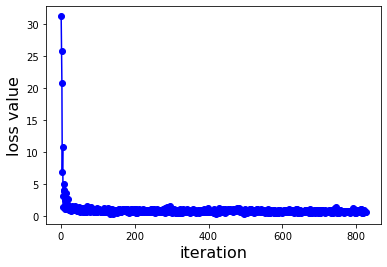

In [15]:
model.train(train, val,test)

In [16]:
y_pred = model.predict(test)

predicting...


In [17]:
y_pred[:5]

[5.959413051605225,
 5.296557426452637,
 5.088376998901367,
 5.496194362640381,
 6.0588812828063965]

In [18]:
test.Label[:5]

0    5.000000
1    5.000000
2    5.000000
3    6.244125
4    8.060481
Name: Label, dtype: float64

In [19]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [20]:
test1_mae = mean_absolute_error(test.Label,y_pred)
test1_rmse = mean_squared_error(test.Label,y_pred, squared=False)
test1_r2 = r2_score(test.Label,y_pred)
print('##########################  Scores of Test1 Data  ##########################')
print('Test1 set MAE of {}: {:.3f}'.format(model, test1_mae))
print('Test1 set RMSE of {}: {:.3f}'.format(model, test1_rmse))
print('Test1 set R2 Score of {}: {:.3f}'.format(model, test1_r2))

##########################  Scores of Test1 Data  ##########################
Test1 set MAE of <DeepPurpose.DTI.DBTA object at 0x7fc7521b28d0>: 0.564
Test1 set RMSE of <DeepPurpose.DTI.DBTA object at 0x7fc7521b28d0>: 0.839
Test1 set R2 Score of <DeepPurpose.DTI.DBTA object at 0x7fc7521b28d0>: 0.133


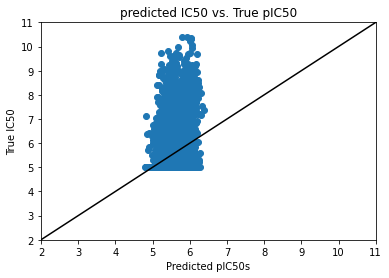

In [21]:

plt.scatter(y_pred, test.Label)
plt.xlabel('Predicted pIC50s')
plt.ylabel('True IC50')
plt.title(r'predicted IC50 vs. True pIC50')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

In [22]:
test.head()

,SMILES,Target Sequence,Label,drug_encoding,target_encoding
0,CN(C)CC1CCN2C=C(C3=CC=CC=C32)C4=C(C5=CN(CCO1)C...,PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...,5.000000,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[P, F, W, K, I, L, N, P, L, L, E, R, G, T, Y, ..."
1,CN1CCC(CC1)COC2=C(C=C3C(=C2)N=CN=C3NC4=C(C=C(C...,MAEKQKHDGRVKIGHYVLGDTLGVGTFGKVKIGEHQLTGHKVAVKI...,5.000000,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[M, A, E, K, Q, K, H, D, G, R, V, K, I, G, H, ..."
2,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEE...,5.000000,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[M, A, A, L, S, G, G, G, G, G, G, A, E, P, G, ..."
3,CCN(CC)CCNC(=O)C1=C(NC(=C1C)C=C2C3=C(C=CC(=C3)...,MTSSLQRPWRVPWLPWTILLVSTAAASQNQERLCAFKDPYQQDLGI...,6.244125,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[M, T, S, S, L, Q, R, P, W, R, V, P, W, L, P, ..."
4,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,MGPEALSSLLLLLLVASGDADMKGHFDPAKCRYALGMQDRTIPDSD...,8.060481,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(...","[M, G, P, E, A, L, S, S, L, L, L, L, L, L, V, ..."


 Use model to predict binding score for other data sets.

In [23]:
target, target_name = dataset.load_SARS_CoV2_Protease_3CL()
repurpose_drugs, repurpose_drugs_name, repurpose_drugs_pubchem_cid = dataset.load_antiviral_drugs()

y_pred = models.repurpose(X_repurpose = repurpose_drugs, target = target, model = model, 
                          drug_names = repurpose_drugs_name, target_name = target_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |      Foscarnet       | SARS-CoV2 3CL Protease |     958.19    |
|  2   |     Rimantadine      | SARS-CoV2 3CL Protease |    1489.59    |
|  3   |      Boceprevir      | SARS-CoV2 3CL Protease |    1534.20    |
|  4   |      Peramivir       | SARS-CoV2 3CL Protease |    1548.28    |
|  5   |      Amantadine      | SARS-CoV2 3CL Protease |    1584.24    |
|  6   |      Zanamivir       | SARS-CoV2 3CL Protease |    1674.56    |
|  7   |     Glecaprevir      | SARS-CoV2 3CL Protease |    1819.30    |
|  8   |     T

In [30]:
target, drugs = dataset.load_IC50_1000_Samples()
y_pred = models.virtual_screening(drugs, target, model)


Downloading...
virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 54  |  Target 54  |      6.05     |
|  2   |  Drug 21  |  Target 21  |      5.96     |
|  3   |  Drug 19  |  Target 19  |      5.77     |
|  4   |  Drug 60  |  Target 60  |      5.68     |
|  5   |  Drug 36  |  Target 36  |      5.66     |
|  6   |  Drug 70  |  Target 70  |      5.62     |
|  7   |  Drug 92  |  Target 92  |      5.60     |
|  8   |  Drug 10  |  Target 10  |      5.59     |
|  9   |  Drug 40  |  Target 40  |      5.58     |
|  10  |  Drug 37  |  Target 37  |      5.58     |
checkout ./result/virtual_screening.txt for the whole list



### Choes other encoders

Here I use Graph convolution net to predict the drug–target binding affinity, in which drugs are represented as graphs where the edges are the bonding of atoms.


In [12]:
drug_encoding, target_encoding = 'DGL_GCN', 'CNN'

In [13]:
train, val, test = utils.data_process(SMILES, Target_seq, y, 
                                drug_encoding, target_encoding, 
                                split_method='random',frac=[0.7,0.1,0.2],
                                random_seed = 1)

Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.


In [14]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                         target_encoding = target_encoding, 
                         cls_hidden_dims = [1024,1024,512], 
                         train_epoch = 5, 
                         LR = 0.001, 
                         batch_size = 128,
                         hidden_dim_drug = 128,
                         mpnn_hidden_size = 128,
                         mpnn_depth = 3, 
                         cnn_target_filters = [32,64,96],
                         cnn_target_kernels = [4,8,12]
                        )

In [15]:
modelgcn = models.model_initialize(**config)

Using backend: pytorch


### Train model

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 30.7997. Total time 0.00194 hours
Training at Epoch 1 iteration 100 with loss 0.75377. Total time 0.14277 hours
Validation at Epoch 1 with loss:0.59773, MSE: 0.70195 , Pearson Correlation: 0.50254 with p-value: 3.77E-192 , Concordance Index: 0.76532
Training at Epoch 2 iteration 0 with loss 0.69418. Total time 0.2575 hours
Training at Epoch 2 iteration 100 with loss 0.71144. Total time 0.38472 hours
Validation at Epoch 2 with loss:0.91850, MSE: 0.58289 , Pearson Correlation: 0.54174 with p-value: 6.42E-229 , Concordance Index: 0.77475
Training at Epoch 3 iteration 0 with loss 0.67510. Total time 0.48555 hours
Training at Epoch 3 iteration 100 with loss 0.50339. Total time 0.61 hours
Validation at Epoch 3 with loss:0.59861, MSE: 0.55573 , Pearson Correlation: 0.60165 with p-value: 1.71E-295 , Concordance Index: 0.80240
Training at Epoch 4 iteration 0 with loss 0.67097. Total time 

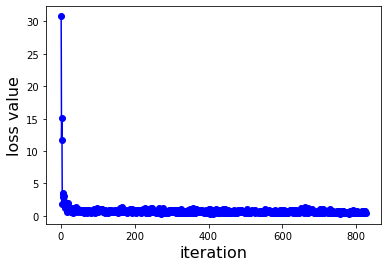

In [16]:
modelgcn.train(train, val,test)

In [17]:
y_pred = modelgcn.predict(test)

predicting...


In [20]:
test1_mae = mean_absolute_error(test.Label,y_pred)
test1_rmse = mean_squared_error(test.Label,y_pred, squared=False)
test1_r2 = r2_score(test.Label,y_pred)
print('##########################  Scores of Test1 Data  ##########################')
print('Test1 set MAE of {}: {:.3f}'.format(modelgcn, test1_mae))
print('Test1 set RMSE of {}: {:.3f}'.format(modelgcn, test1_rmse))
print('Test1 set R2 Score of {}: {:.3f}'.format(modelgcn, test1_r2))

##########################  Scores of Test1 Data  ##########################
Test1 set MAE of <DeepPurpose.DTI.DBTA object at 0x7fef7c7d1890>: 0.484
Test1 set RMSE of <DeepPurpose.DTI.DBTA object at 0x7fef7c7d1890>: 0.713
Test1 set R2 Score of <DeepPurpose.DTI.DBTA object at 0x7fef7c7d1890>: 0.375


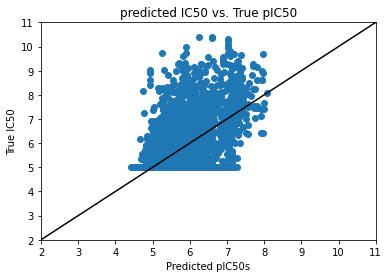

In [21]:
plt.scatter(y_pred, test.Label)
plt.xlabel('Predicted pIC50s')
plt.ylabel('True IC50')
plt.title(r'predicted IC50 vs. True pIC50')
plt.xlim([2, 11])
plt.ylim([2, 11])
plt.plot([2, 11], [2, 11], color='k')
plt.show()

In [26]:
target, target_name = dataset.load_SARS_CoV2_Protease_3CL()
repurpose_drugs, repurpose_drugs_name, repurpose_drugs_pubchem_cid = dataset.load_antiviral_drugs()
y_pred = models.repurpose(X_repurpose = repurpose_drugs, target = target, model = modelgcn, 
                          drug_names = repurpose_drugs_name, target_name = target_name, 
                          result_folder = "./result/", convert_y = True)

repurposing...
Drug Target Interaction Prediction Mode...
in total: 82 drug-target pairs
encoding drug...
unique drugs: 81
encoding protein...
unique target sequence: 1
Done.
predicting...
---------------
Drug Repurposing Result for SARS-CoV2 3CL Protease
+------+----------------------+------------------------+---------------+
| Rank |      Drug Name       |      Target Name       | Binding Score |
+------+----------------------+------------------------+---------------+
|  1   |     Enfuvirtide      | SARS-CoV2 3CL Protease |      0.00     |
|  2   |      Telaprevir      | SARS-CoV2 3CL Protease |     26.10     |
|  3   |       Imunovir       | SARS-CoV2 3CL Protease |     33.08     |
|  4   |     Glecaprevir      | SARS-CoV2 3CL Protease |     48.69     |
|  5   |      Indinavir       | SARS-CoV2 3CL Protease |     53.60     |
|  6   |      Saquinavir      | SARS-CoV2 3CL Protease |     55.01     |
|  7   |     Grazoprevir      | SARS-CoV2 3CL Protease |     128.48    |
|  8   |      

In [27]:
target, drugs = dataset.load_IC50_1000_Samples()
y_pred = models.virtual_screening(drugs, target, modelgcn)


Downloading...
virtual screening...
Drug Target Interaction Prediction Mode...
in total: 100 drug-target pairs
encoding drug...
unique drugs: 100
encoding protein...
unique target sequence: 91
Done.
predicting...
---------------
Virtual Screening Result
+------+-----------+-------------+---------------+
| Rank | Drug Name | Target Name | Binding Score |
+------+-----------+-------------+---------------+
|  1   |  Drug 80  |  Target 80  |      7.49     |
|  2   |  Drug 39  |  Target 39  |      6.48     |
|  3   |  Drug 17  |  Target 17  |      6.46     |
|  4   |  Drug 15  |  Target 15  |      6.36     |
|  5   |  Drug 88  |  Target 88  |      6.34     |
|  6   |  Drug 21  |  Target 21  |      6.31     |
|  7   |  Drug 18  |  Target 18  |      6.27     |
|  8   |  Drug 13  |  Target 13  |      6.25     |
|  9   |  Drug 44  |  Target 44  |      6.16     |
|  10  |  Drug 62  |  Target 62  |      6.15     |
checkout ./result/virtual_screening.txt for the whole list



The results show that this method gains better performance in the task of drug–target binding affinity prediction.